In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import numpy.random as npr

import matplotlib.pyplot as plt
from matplotlib.cm import jet
%matplotlib inline

In [3]:
from background import NodeAndTimeAndMarkBackground, UniformTimeBackground, GaussianBackground
from clusters import NodeAndTimeAndMarkCluster, ExponentialTimeCluster, GaussianCluster, DefaultClusterFactory
from models import DirichletProcessMixtureModel, NeymanScottModel
from util import permute_to_match, onehot, compute_state_overlap

In [4]:
npr.seed(1)

In [5]:
# Make a Neyman-Scott model with gaussian marks
T = 100           # time window
M = 1            # number of nodes
data_dim = 1      # dimensionality of marks (e.g. vocab size in multinomial model)
lmbda0 = 100      # background rate of events (across all nodes)
tau = 5           # time constant of exponential impulse responses
mu = 20           # rate of latent events
alpha = 1         # shape of gamma prior on latent event weights
beta = 1/20       # rate of gamma prior on latent event weights

# specify hyperparameters of cluster marks
niw_hypers = dict(mu0=np.zeros(data_dim),
                  lmbda=1,
                  Psi=np.eye(data_dim),
                  nu=data_dim+1)

In [6]:
bkgd_class = NodeAndTimeAndMarkBackground
bkgd_hypers = dict(
    num_nodes=M,
    node_distribution=np.ones(M) / M,
    time_class=UniformTimeBackground,
    time_kwargs=dict(T=T),
    mark_class=GaussianBackground,
    mark_kwargs=dict(data_dim=data_dim),
    )

cluster_class = NodeAndTimeAndMarkCluster
cluster_hypers = dict(
    num_nodes=M,
    node_concentration=0.5,
    time_class=ExponentialTimeCluster,
    time_kwargs=dict(T=T, tau=tau),
    mark_class=GaussianCluster,
    mark_kwargs=niw_hypers,
    )

# Generate synthetic data and compare Gibbs to RJMCMC

In [7]:
true_model = NeymanScottModel(mu, alpha, beta, lmbda0, 
                              bkgd_class(**bkgd_hypers), 
                              DefaultClusterFactory(cluster_class, cluster_hypers))

# Sample from the model
sample_kwargs = dict(time_kwargs=dict(), mark_kwargs=dict())
data, parents, clusters, weights = true_model.generate(**sample_kwargs)
nodes, times, marks = data[:, 0], data[:, 1], data[:, 2:]

# Only keep the valid times
# valid = times < T
valid = np.ones_like(times, dtype=bool)
nodes = nodes[valid]
times = times[valid]
marks = marks[valid]
parents = parents[valid]

# Sort the data by time
perm = np.argsort(times)
nodes = nodes[perm]
times = times[perm]
marks = marks[perm]
parents = parents[perm]
data = np.column_stack((nodes, times, marks))

In [8]:
%debug

ERROR:root:No traceback has been produced, nothing to debug.


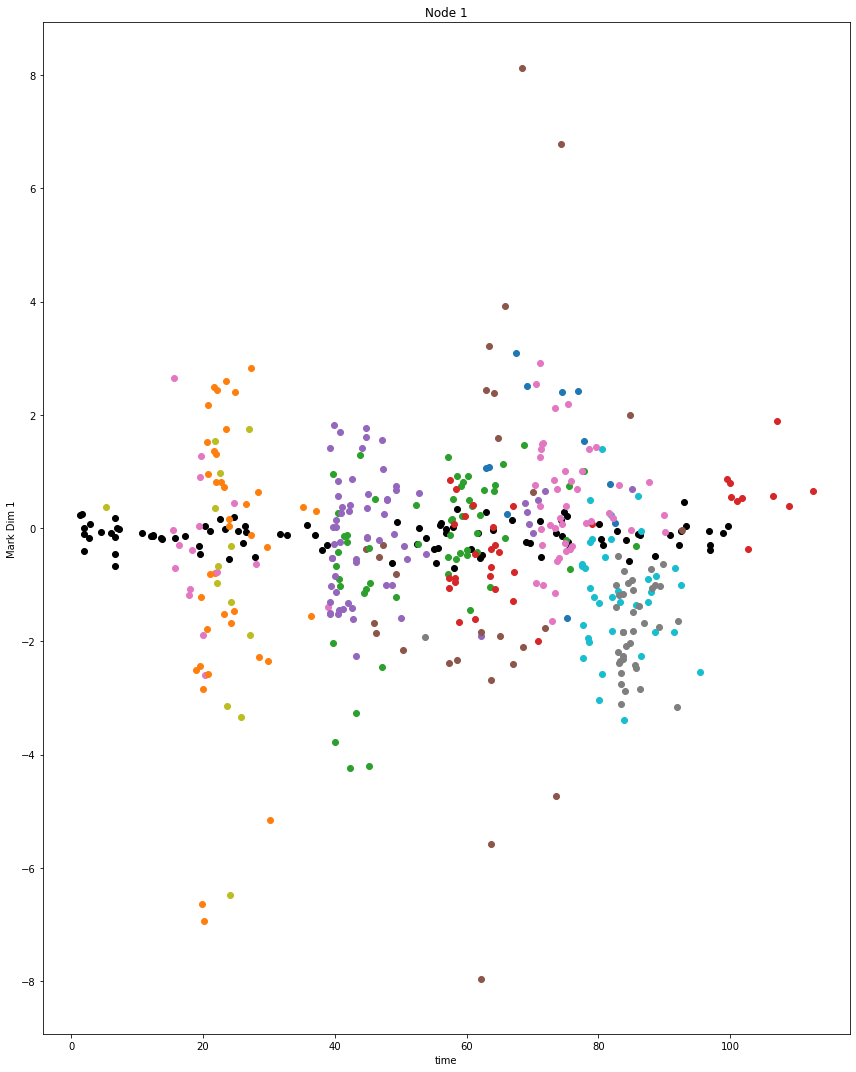

In [9]:
plt.figure(figsize=(12, 15))
ylim = 1.1 * abs(marks[:, 0]).max()
for m in range(M):
    plt.subplot(M, 1, m+1)
    for z in np.unique(parents):
        inds = np.where((parents == z) & (nodes == m))[0]
        plt.plot(times[inds], marks[inds, 0], 'o' if z >= 0 else 'ko')
    
    plt.ylabel("Mark Dim 1")
    plt.ylim(-ylim, ylim)
    if m == M-1:
        plt.xlabel("time")
    else:
        plt.xticks([])
        
    plt.title("Node {}".format(m+1))

plt.tight_layout()

In [10]:
# # Fit the correct model
# num_samples = 100
# # nsm = NeymanScottModel(mu, alpha, beta, lmbda0, 
# #                        bkgd_class(**bkgd_hypers), 
# #                        DefaultClusterFactory(cluster_class, cluster_hypers))

# # Fit the model
# print("true num clusters: ", len(clusters))

# gibbs_samples = true_model.gibbs_sample_posterior(data, num_samples=num_samples, init_method="prior")

In [11]:
# Fit the correct model with RJMCMC
num_samples = 10000
# nsm = NeymanScottModel(mu, alpha, beta, lmbda0, 
#                        bkgd_class(**bkgd_hypers), 
#                        DefaultClusterFactory(cluster_class, cluster_hypers))
rjmcmc_samples = true_model.rjmcmc_sample_posterior(data, num_samples=num_samples, init_method="background")

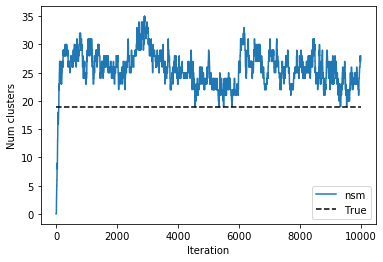

In [12]:
# Plot the number of clusters over samples
plt.figure()
# plt.plot([s["num_clusters"] for s in gibbs_samples], label="nsm")
plt.plot([s["num_clusters"] for s in rjmcmc_samples], label="nsm")
plt.plot([0, len(rjmcmc_samples)], [len(clusters), len(clusters)], '--k', label="True")
plt.xlabel("Iteration")
plt.ylabel("Num clusters")
plt.legend(loc="lower right")
plt.show()

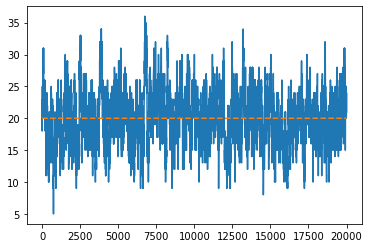

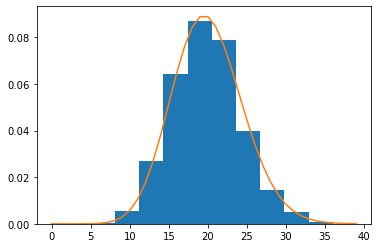

In [15]:
k = int(mu)
k_smpls = [k]
n_smpls = 20000
for i in range(n_smpls):
    move = npr.rand() < 0.5
    if move == 1:
        p_acc = mu / (k + 1)
        if npr.rand() < p_acc:
            k += 1
            
    else:
        # remove
        p_acc = k / mu
        if npr.rand() < p_acc:
            k -= 1
            
    k_smpls.append(k)
    
plt.figure()
plt.plot(k_smpls)
plt.plot(mu * np.ones(n_smpls), '--')

from scipy.stats import poisson
plt.figure()
plt.hist(k_smpls, density=True)
plt.plot(np.arange(2 * mu), poisson.pmf(np.arange(2 * mu), mu))